In [25]:
import pandas as pd
import numpy as np

from datetime import datetime as dt
import datetime
from dateutil.relativedelta import relativedelta

from tqdm import tqdm_notebook
import tqdm

import os
import warnings

warnings.filterwarnings('ignore')

In [26]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [94]:
import matplotlib.pylab as plt
import seaborn as sns

In [27]:
n_days = 20

start_date = datetime.datetime(2023, 4, 3)

start_dates = [start_date + relativedelta(days = i) for i in range(n_days + 1)]
start_dates = [i.date().strftime('%Y_%m_%d') for i in start_dates]

In [66]:
df = pd.DataFrame()  
pair = 'BTCEUR'

tc = 'received_time_r'

for date in start_dates:
    
    lt_df = pd.read_csv(f'~/LAST_TRADE_{pair}_{date}.csv').rename(columns = {'event_time_r': 'received_time_r'})

    lt_df.columns = [tc] + [i + '_LT' for i in lt_df.columns[1:]]

    df = df.append(lt_df)

extremes = dict()

for c in df.columns[1:-1]:
    if df[c].max() == np.inf or df[c].max() > np.inf:
        extremes[c] = 1
    elif df[c].min() == -np.inf or df[c].min() < -np.inf:
        extremes[c] = 1
    else:
        pass
    
for c in extremes.keys():
    df[c] = np.where(df[c] >= np.inf, df[c][df[c] < np.inf].quantile(0.9), df[c])
    df[c] = np.where(df[c] <= -np.inf, df[c][df[c] > -np.inf].quantile(0.1), df[c])
    

no_variation = dict()

for c in df.columns[1:-1]:
    if np.nanstd(df[c]) == 0:
        no_variation[c] = 1

df.drop(columns = no_variation.keys(), inplace = True) 

df['minute'] = df['received_time_r'].apply(lambda x: x[-5:-3])
df['second'] = df['received_time_r'].apply(lambda x: x[-2:])

minutes_df = pd.get_dummies(df['minute'], prefix = 'minute', drop_first = True).astype(int)
seconds_df = pd.get_dummies(df['second'], prefix = 'second', drop_first = True).astype(int)

df.drop(columns = ['minute', 'second'], inplace = True)

df = pd.concat([df, minutes_df], axis = 1)
df = pd.concat([df, seconds_df], axis = 1)

del minutes_df
del seconds_df

df['received_time_r'] = df['received_time_r'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))


In [85]:
def mae(y_true, y_pred):
    return np.nanmean(abs(y_true - y_pred))

def rmae(y_true, y_pred):
    return mae(y_true, y_pred) / np.nanmean(y_true)

def sliding_window_cv(data, target, min_sample, timestamp_col, window, algorythm, algo_params, scaling = False):
    
    date_col = 'date_col'
    
    data[date_col] = data[timestamp_col].apply(lambda x: x.date())
    start_date, end_date = data[date_col].min(), data[date_col].max()
    
    delta = (end_date - start_date).days
    n_iter = delta - window - min_sample + 1
    
    results = dict()
    
    for i in tqdm.tqdm_notebook(range(n_iter + 1)):
        delta = relativedelta(days = +i)
        start, end = start_date + delta, start_date + delta + relativedelta(days = +min_sample)
        
        train = data[(data[date_col] >= start) & (data[date_col] < end)]
        test = data[(data[date_col] >= end) & (data[date_col] < end + relativedelta(days = +window))]
        
        print(train[date_col].min(), train[date_col].max(), test[date_col].unique())
        
        x_train, y_train = train.drop(columns = [target, timestamp_col, date_col]), train[target]
        x_test, y_test = test.drop(columns = [target, timestamp_col, date_col]), test[target]
        
        if scaling:
            sc = StandardScaler()
            x_train = sc.fit_transform(x_train)
            x_test = sc.transform(x_test)
            
        model = algorythm(**algo_params)
        model.fit(x_train, y_train)
        
        y_pred = model.predict(x_test)
        
        fi = pd.DataFrame(zip(train.drop(columns = [target, timestamp_col, date_col]).columns, 
                              model.feature_importances_), 
                          columns = ['feature', 'importance']).sort_values(by = 'importance', ascending = False)
        
        results[end] = {'mae': mae(y_test, y_pred), 'rmae': rmae(y_test, y_pred), 'fi': fi}
        
    return results

def expanding_window_cv(data, target, min_sample, timestamp_col, window, algorythm, algo_params, scaling = False):
    
    date_col = 'date_col'
    
    data[date_col] = data[timestamp_col].apply(lambda x: x.date())
    start_date, end_date = data[date_col].min(), data[date_col].max()
    
    delta = (end_date - start_date).days
    n_iter = delta - window - min_sample + 1
    
    results = dict()
    
    for i in range(n_iter + 1):
        delta = relativedelta(days = +i)
        start, end = start_date, start_date + delta + relativedelta(days = +min_sample)
        
        train = data[(data[date_col] >= start) & (data[date_col] < end)]
        test = data[(data[date_col] >= end) & (data[date_col] < end + relativedelta(days = +window))]
        
        print(train[date_col].min(), train[date_col].max(), test[date_col].unique())
        
        x_train, y_train = train.drop(columns = [target, timestamp_col, date_col]), train[target]
        x_test, y_test = test.drop(columns = [target, timestamp_col, date_col]), test[target]
        
        if scaling:
            sc = StandardScaler()
            x_train = sc.fit_transform(x_train)
            x_test = sc.transform(x_test)
            
        model = algorythm(**algo_params)
        model.fit(x_train, y_train)
        
        y_pred = model.predict(x_test)
        
        fi = pd.DataFrame(zip(train.drop(columns = [target, timestamp_col, date_col]).columns, 
                      model.feature_importances_), 
                  columns = ['feature', 'importance']).sort_values(by = 'importance', ascending = False)
        
        results[end] = {'mae': mae(y_test, y_pred), 'rmae': rmae(y_test, y_pred), 'fi': fi}
        
    return results


In [86]:
params = {
          'n_estimators': 500, 
          'max_depth': 6, 
          'learning_rate': 0.05, 
          'reg_alpha': 10, 
          'random_state': 81, 
          'n_jobs': 10
         }

In [87]:
res_sliding = sliding_window_cv(df, 'rv_LT', 7, 'received_time_r', 1, XGBRegressor, params, scaling = True)

  0%|          | 0/14 [00:00<?, ?it/s]

2023-04-03 2023-04-09 [datetime.date(2023, 4, 10)]
2023-04-04 2023-04-10 [datetime.date(2023, 4, 11)]
2023-04-05 2023-04-11 [datetime.date(2023, 4, 12)]
2023-04-06 2023-04-12 [datetime.date(2023, 4, 13)]
2023-04-07 2023-04-13 [datetime.date(2023, 4, 14)]
2023-04-08 2023-04-14 [datetime.date(2023, 4, 15)]
2023-04-09 2023-04-15 [datetime.date(2023, 4, 16)]
2023-04-10 2023-04-16 [datetime.date(2023, 4, 17)]
2023-04-11 2023-04-17 [datetime.date(2023, 4, 18)]
2023-04-12 2023-04-18 [datetime.date(2023, 4, 19)]
2023-04-13 2023-04-19 [datetime.date(2023, 4, 20)]
2023-04-14 2023-04-20 [datetime.date(2023, 4, 21)]
2023-04-15 2023-04-21 [datetime.date(2023, 4, 22)]
2023-04-16 2023-04-22 [datetime.date(2023, 4, 23)]


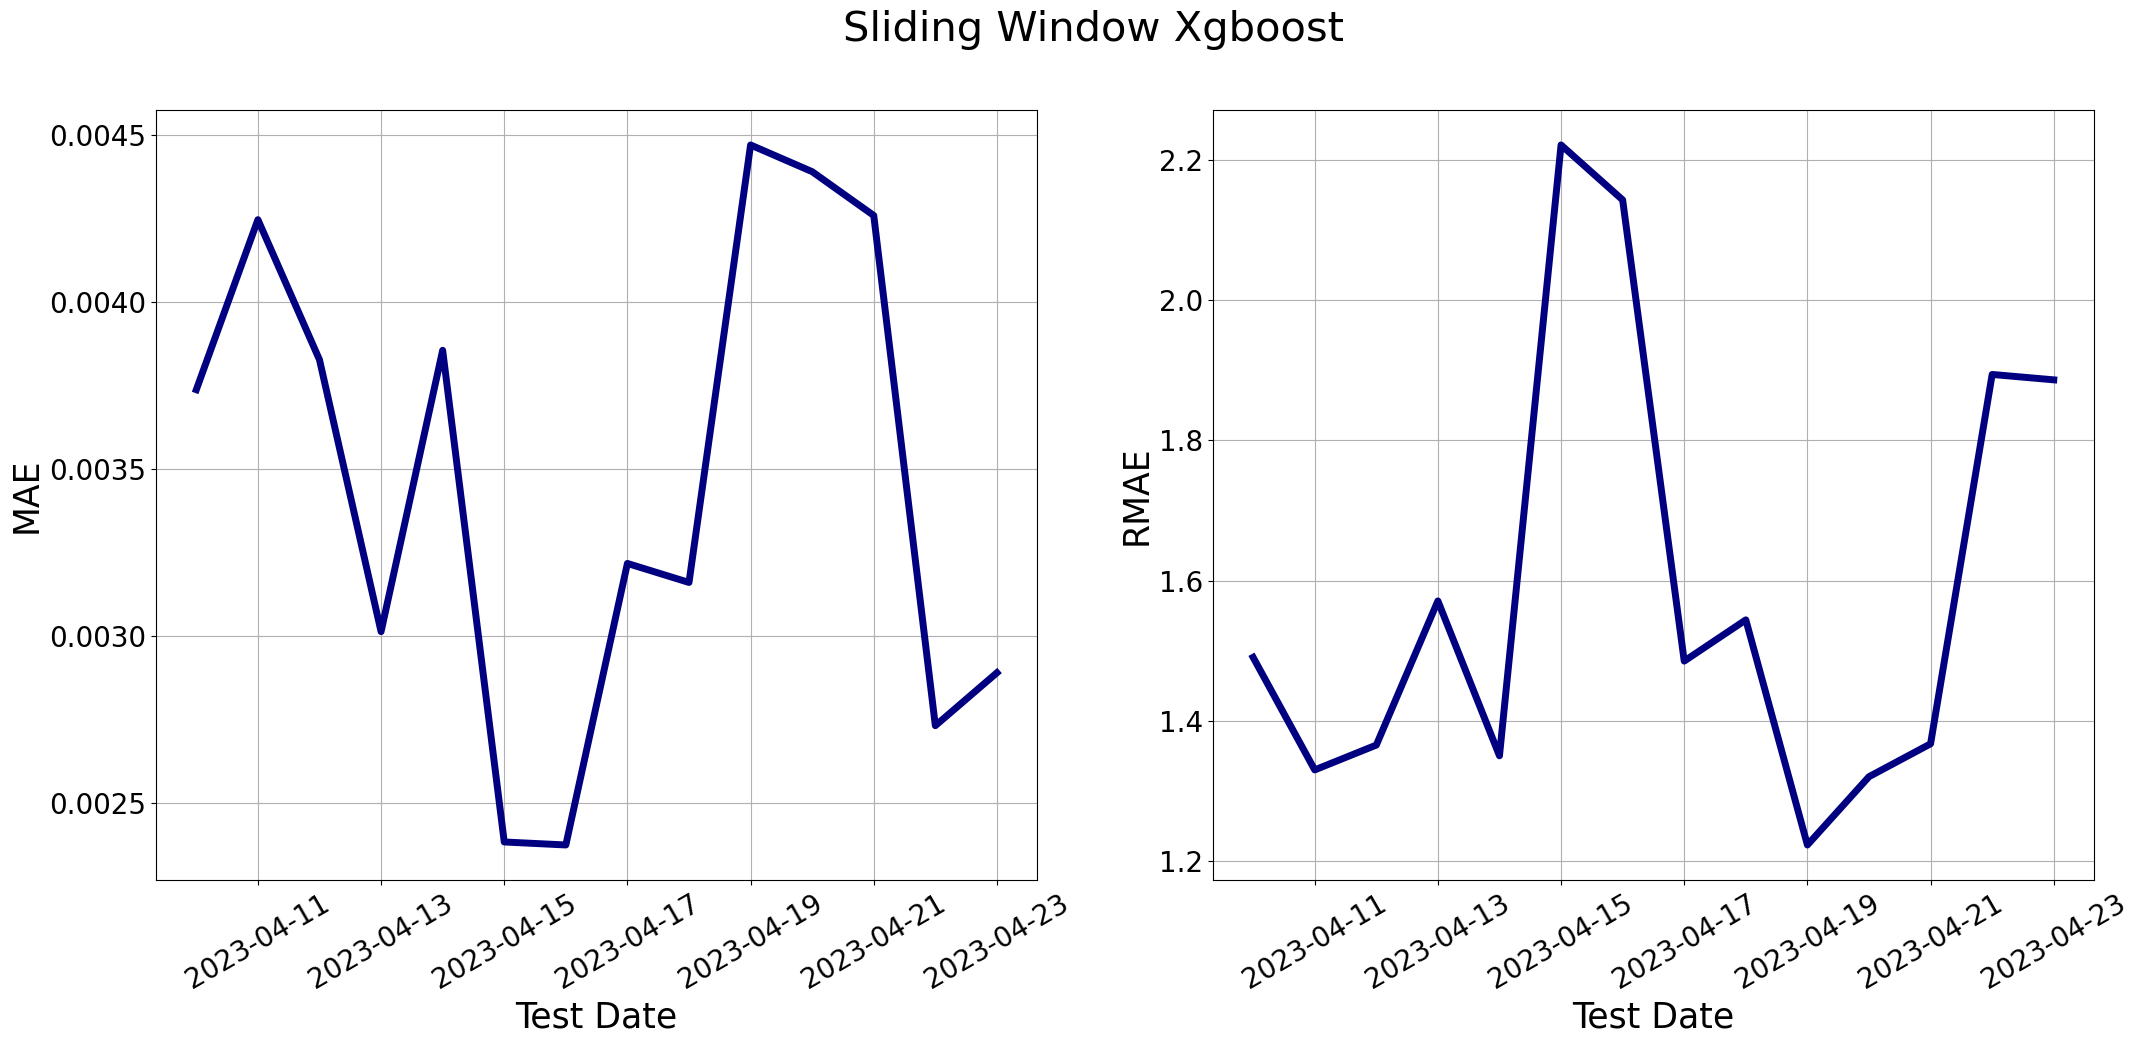

In [102]:
sliding_mae = pd.DataFrame({i: j['mae'] for i,j in res_sliding.items()}.items(), columns = ['test_date', 'mae'])
sliding_rmae = pd.DataFrame({i: j['rmae'] for i,j in res_sliding.items()}.items(), columns = ['test_date', 'rmae'])

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (25, 10))

sns.lineplot(sliding_mae['test_date'], sliding_mae['mae'], linewidth = 5, color = 'navy', ax = ax[0])
sns.lineplot(sliding_rmae['test_date'], sliding_rmae['rmae'], linewidth = 5, color = 'navy', ax = ax[1])
for i in ax:
    i.grid()
    i.tick_params(labelsize = 20)
    i.set_xlabel('Test Date', fontsize = 25)
    i.xaxis.set_tick_params(rotation = 30)

ax[0].set_ylabel('MAE', fontsize = 25)
ax[1].set_ylabel('RMAE', fontsize = 25)
    
plt.suptitle('Sliding Window Xgboost', fontsize = 30)
plt.savefig('Sliding Window Xgboost.jpg', bbox_tight = True)
plt.show()

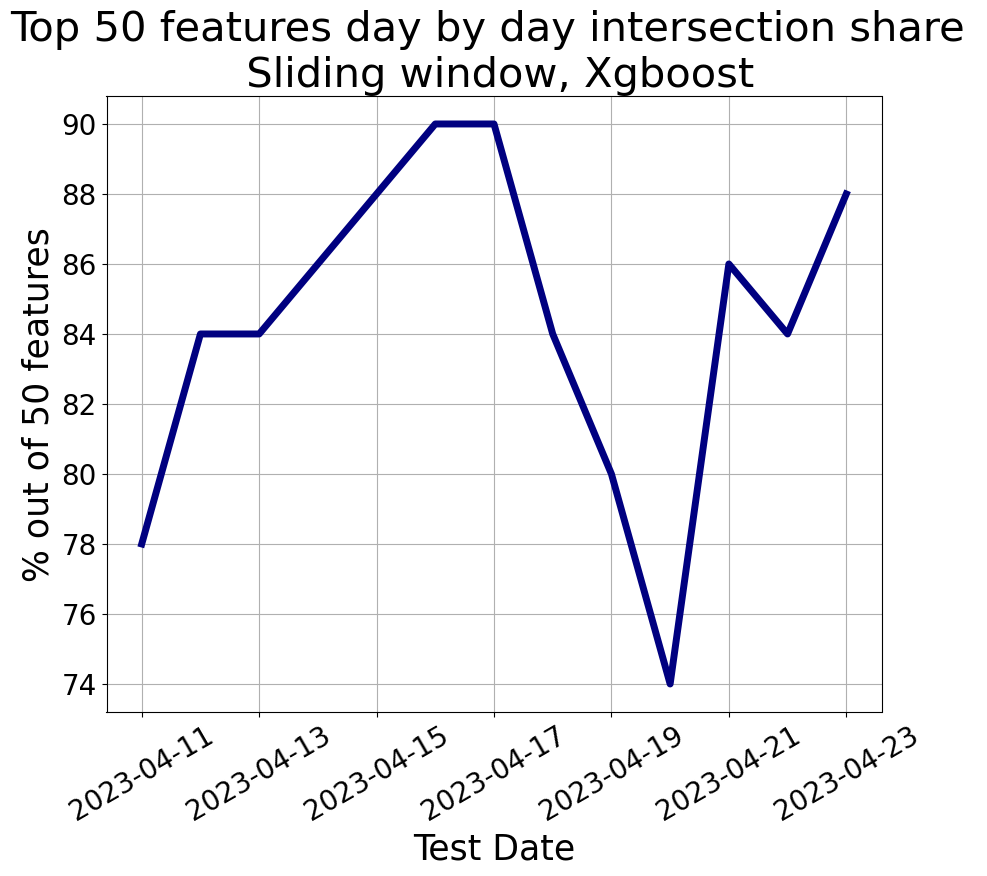

In [138]:
fi = pd.DataFrame()

for i,j in res_sliding.items():
    tmp_df = res_sliding[i]['fi']
    tmp_df['date'] = i
    
    fi = fi.append(tmp_df)
    
fi_50 = fi.groupby('date').head(50)
fi_50_sets = fi_50.groupby('date')['feature'].apply(set).reset_index(name = 'fi_set')
fi_50_sets['fi_set_l1'] = fi_50_sets['fi_set'].shift(1)

fi_50_sets.dropna(inplace = True)

fi_50_intersections = fi_50_sets.apply(lambda x: x['fi_set'].intersection(x['fi_set_l1']), axis = 1)
fi_50_intersections = fi_50_intersections.apply(len) / 50 * 100
fi_50_intersections.index = fi_50_sets['date']

fi_50_intersections.plot(color = 'navy', figsize = (10, 8), linewidth = 5)
plt.xlabel('Test Date', fontsize = 25)
plt.ylabel('% out of 50 features', fontsize = 25)
plt.tick_params(labelsize = 20)
plt.grid()
plt.xticks(rotation = 30)
plt.title('Top 50 features day by day intersection share \n Sliding window, Xgboost', fontsize = 30)
plt.savefig('Top 50 features day by day intersection share Sliding window, Xgboost.jpg', bbox_tight = True)
plt.show()

In [156]:
all_features = set()

for v in fi_50_sets['fi_set'].values:
    for k in v:
        all_features.add(k)
        
for v in fi_50_sets['fi_set'].values:
    all_features = all_features.intersection(v)
    
len(all_features) / 50 * 100

64.0

In [157]:
res_expanding = expanding_window_cv(df, 'rv_LT', 7, 'received_time_r', 1, XGBRegressor, params, scaling = True)

2023-04-03 2023-04-09 [datetime.date(2023, 4, 10)]
2023-04-03 2023-04-10 [datetime.date(2023, 4, 11)]
2023-04-03 2023-04-11 [datetime.date(2023, 4, 12)]
2023-04-03 2023-04-12 [datetime.date(2023, 4, 13)]
2023-04-03 2023-04-13 [datetime.date(2023, 4, 14)]
2023-04-03 2023-04-14 [datetime.date(2023, 4, 15)]
2023-04-03 2023-04-15 [datetime.date(2023, 4, 16)]
2023-04-03 2023-04-16 [datetime.date(2023, 4, 17)]
2023-04-03 2023-04-17 [datetime.date(2023, 4, 18)]
2023-04-03 2023-04-18 [datetime.date(2023, 4, 19)]
2023-04-03 2023-04-19 [datetime.date(2023, 4, 20)]
2023-04-03 2023-04-20 [datetime.date(2023, 4, 21)]
2023-04-03 2023-04-21 [datetime.date(2023, 4, 22)]
2023-04-03 2023-04-22 [datetime.date(2023, 4, 23)]


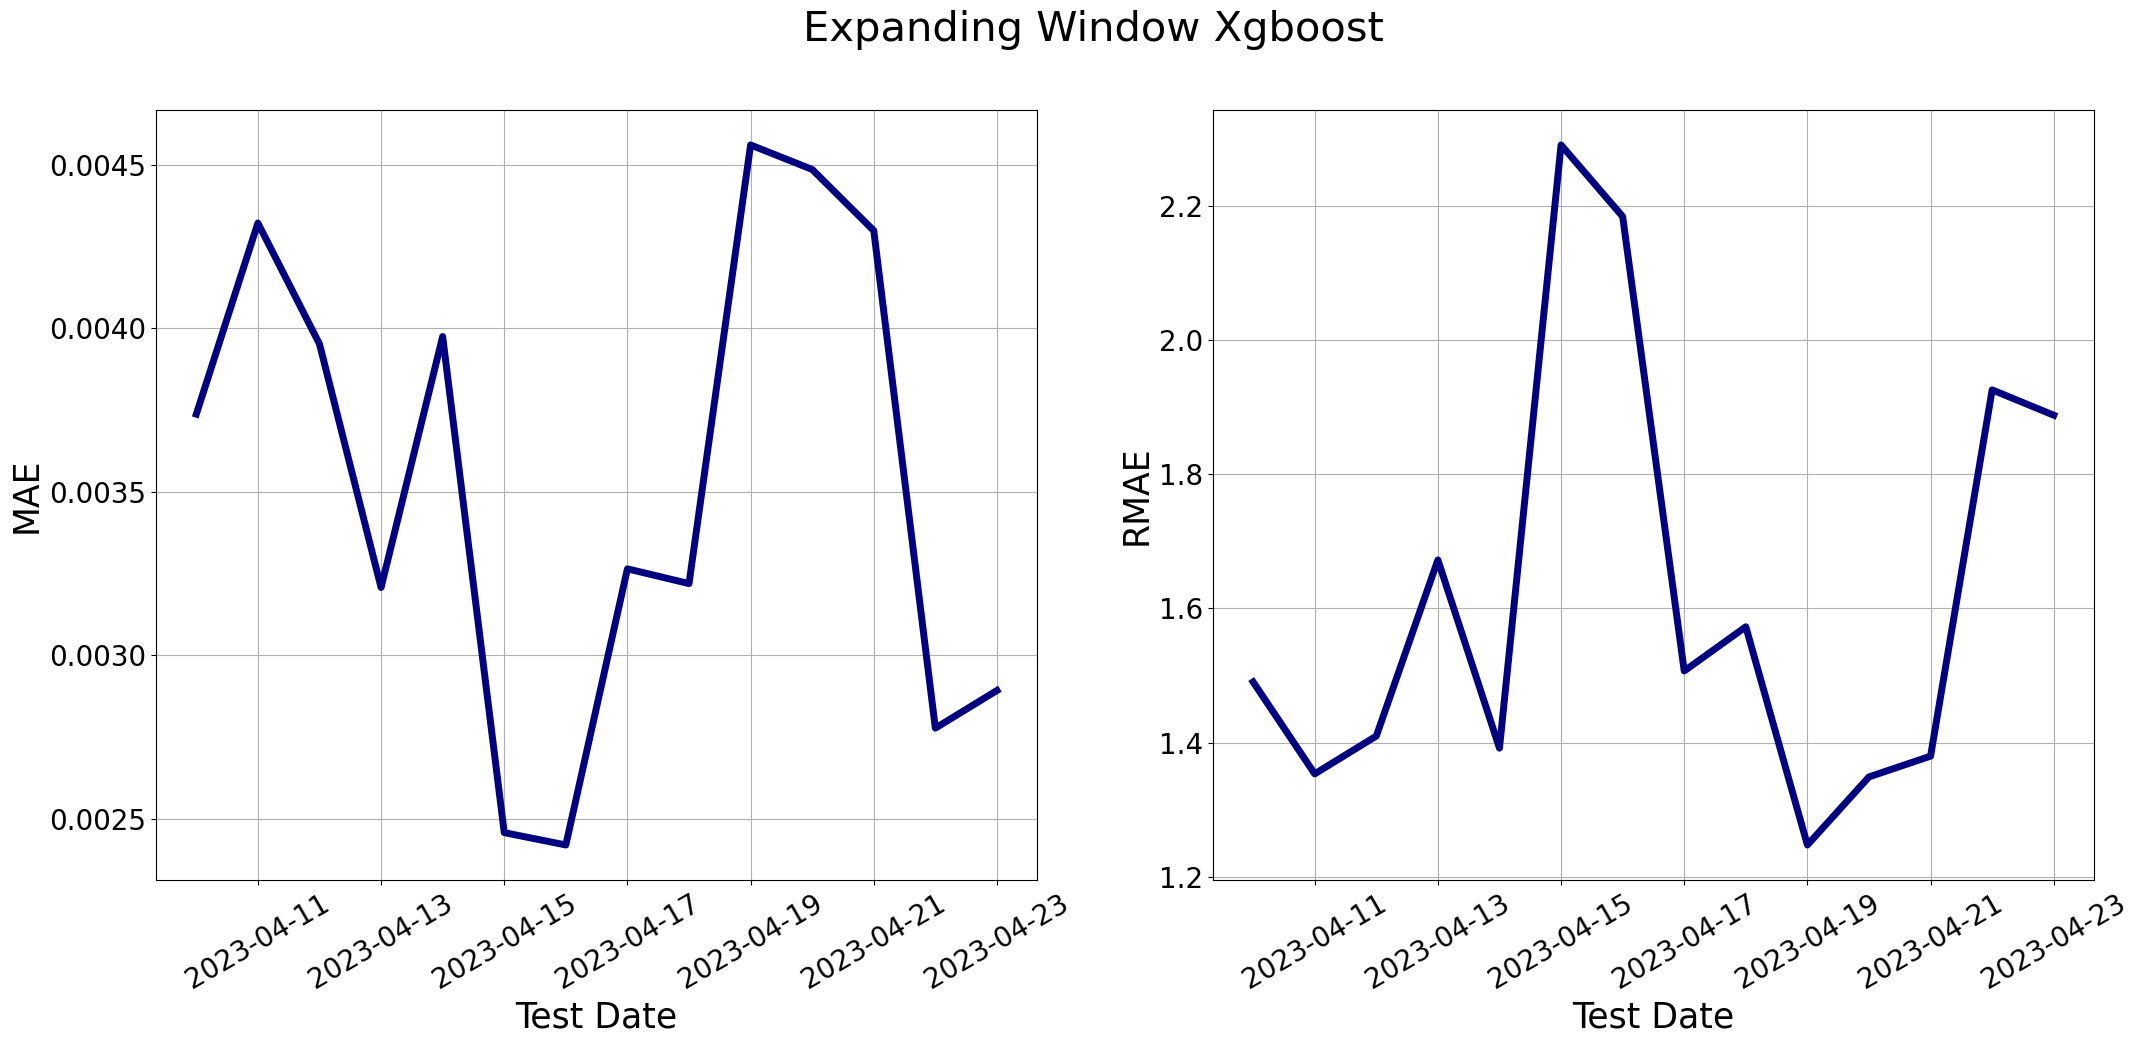

In [160]:
expanding_mae = pd.DataFrame({i: j['mae'] for i,j in res_expanding.items()}.items(), columns = ['test_date', 'mae'])
expanding_rmae = pd.DataFrame({i: j['rmae'] for i,j in res_expanding.items()}.items(), columns = ['test_date', 'rmae'])

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (25, 10))

sns.lineplot(expanding_mae['test_date'], expanding_mae['mae'], linewidth = 5, color = 'navy', ax = ax[0])
sns.lineplot(expanding_rmae['test_date'], expanding_rmae['rmae'], linewidth = 5, color = 'navy', ax = ax[1])
for i in ax:
    i.grid()
    i.tick_params(labelsize = 20)
    i.set_xlabel('Test Date', fontsize = 25)
    i.xaxis.set_tick_params(rotation = 30)

ax[0].set_ylabel('MAE', fontsize = 25)
ax[1].set_ylabel('RMAE', fontsize = 25)
    
plt.suptitle('Expanding Window Xgboost', fontsize = 30)
plt.savefig('Expanding Window Xgboost.jpg', bbox_tight = True)
plt.show()

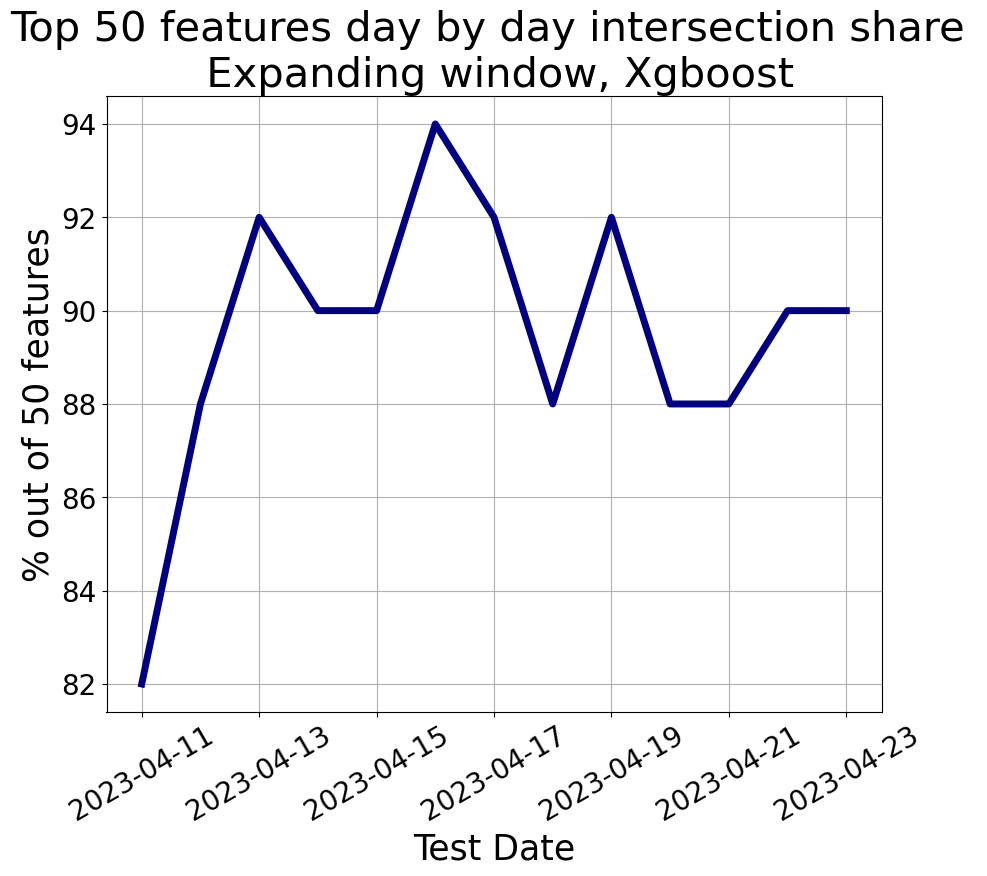

In [161]:
fi = pd.DataFrame()

for i,j in res_expanding.items():
    tmp_df = res_expanding[i]['fi']
    tmp_df['date'] = i
    
    fi = fi.append(tmp_df)
    
fi_50 = fi.groupby('date').head(50)
fi_50_sets = fi_50.groupby('date')['feature'].apply(set).reset_index(name = 'fi_set')
fi_50_sets['fi_set_l1'] = fi_50_sets['fi_set'].shift(1)

fi_50_sets.dropna(inplace = True)

fi_50_intersections = fi_50_sets.apply(lambda x: x['fi_set'].intersection(x['fi_set_l1']), axis = 1)
fi_50_intersections = fi_50_intersections.apply(len) / 50 * 100
fi_50_intersections.index = fi_50_sets['date']

fi_50_intersections.plot(color = 'navy', figsize = (10, 8), linewidth = 5)
plt.xlabel('Test Date', fontsize = 25)
plt.ylabel('% out of 50 features', fontsize = 25)
plt.tick_params(labelsize = 20)
plt.grid()
plt.xticks(rotation = 30)
plt.title('Top 50 features day by day intersection share \n Expanding window, Xgboost', fontsize = 30)
plt.savefig('Top 50 features day by day intersection share Expanding window, Xgboost.jpg', bbox_tight = True)
plt.show()

In [162]:
all_features = set()

for v in fi_50_sets['fi_set'].values:
    for k in v:
        all_features.add(k)
        
for v in fi_50_sets['fi_set'].values:
    all_features = all_features.intersection(v)
    
len(all_features) / 50 * 100

68.0

In [168]:
def sliding_window_cv(data, target, min_sample, timestamp_col, window, algorythm, algo_params, scaling = False):
    
    date_col = 'date_col'
    
    data[date_col] = data[timestamp_col].apply(lambda x: x.date())
    start_date, end_date = data[date_col].min(), data[date_col].max()
    
    delta = (end_date - start_date).days
    n_iter = delta - window - min_sample + 1
    
    results = dict()
    
    for i in tqdm.tqdm_notebook(range(n_iter + 1)):
        delta = relativedelta(days = +i)
        start, end = start_date + delta, start_date + delta + relativedelta(days = +min_sample)
        
        train = data[(data[date_col] >= start) & (data[date_col] < end)]
        test = data[(data[date_col] >= end) & (data[date_col] < end + relativedelta(days = +window))]
        
        print(train[date_col].min(), train[date_col].max(), test[date_col].unique())
        
        x_train, y_train = train.drop(columns = [target, timestamp_col, date_col]), train[target]
        x_test, y_test = test.drop(columns = [target, timestamp_col, date_col]), test[target]
        
        if scaling:
            sc = StandardScaler()
            x_train = sc.fit_transform(x_train)
            x_test = sc.transform(x_test)
            
        model = algorythm(**algo_params)
        model.fit(x_train, y_train)
        
        y_pred = model.predict(x_test)
        
        results[end] = {'mae': mae(y_test, y_pred), 'rmae': rmae(y_test, y_pred)}
        
    return results

def expanding_window_cv(data, target, min_sample, timestamp_col, window, algorythm, algo_params, scaling = False):
    
    date_col = 'date_col'
    
    data[date_col] = data[timestamp_col].apply(lambda x: x.date())
    start_date, end_date = data[date_col].min(), data[date_col].max()
    
    delta = (end_date - start_date).days
    n_iter = delta - window - min_sample + 1
    
    results = dict()
    
    for i in range(n_iter + 1):
        delta = relativedelta(days = +i)
        start, end = start_date, start_date + delta + relativedelta(days = +min_sample)
        
        train = data[(data[date_col] >= start) & (data[date_col] < end)]
        test = data[(data[date_col] >= end) & (data[date_col] < end + relativedelta(days = +window))]
        
        print(train[date_col].min(), train[date_col].max(), test[date_col].unique())
        
        x_train, y_train = train.drop(columns = [target, timestamp_col, date_col]), train[target]
        x_test, y_test = test.drop(columns = [target, timestamp_col, date_col]), test[target]
        
        if scaling:
            sc = StandardScaler()
            x_train = sc.fit_transform(x_train)
            x_test = sc.transform(x_test)
            
        model = algorythm(**algo_params)
        model.fit(x_train, y_train)
        
        y_pred = model.predict(x_test)
        
        results[end] = {'mae': mae(y_test, y_pred), 'rmae': rmae(y_test, y_pred)}
        
    return results


In [169]:
params = {
          'alpha': 10
         }

In [170]:
res_sliding_lasso = sliding_window_cv(df, 'rv_LT', 7, 'received_time_r', 1, Lasso, params, scaling = True)

  0%|          | 0/14 [00:00<?, ?it/s]

2023-04-03 2023-04-09 [datetime.date(2023, 4, 10)]
2023-04-04 2023-04-10 [datetime.date(2023, 4, 11)]
2023-04-05 2023-04-11 [datetime.date(2023, 4, 12)]
2023-04-06 2023-04-12 [datetime.date(2023, 4, 13)]
2023-04-07 2023-04-13 [datetime.date(2023, 4, 14)]
2023-04-08 2023-04-14 [datetime.date(2023, 4, 15)]
2023-04-09 2023-04-15 [datetime.date(2023, 4, 16)]
2023-04-10 2023-04-16 [datetime.date(2023, 4, 17)]
2023-04-11 2023-04-17 [datetime.date(2023, 4, 18)]
2023-04-12 2023-04-18 [datetime.date(2023, 4, 19)]
2023-04-13 2023-04-19 [datetime.date(2023, 4, 20)]
2023-04-14 2023-04-20 [datetime.date(2023, 4, 21)]
2023-04-15 2023-04-21 [datetime.date(2023, 4, 22)]
2023-04-16 2023-04-22 [datetime.date(2023, 4, 23)]


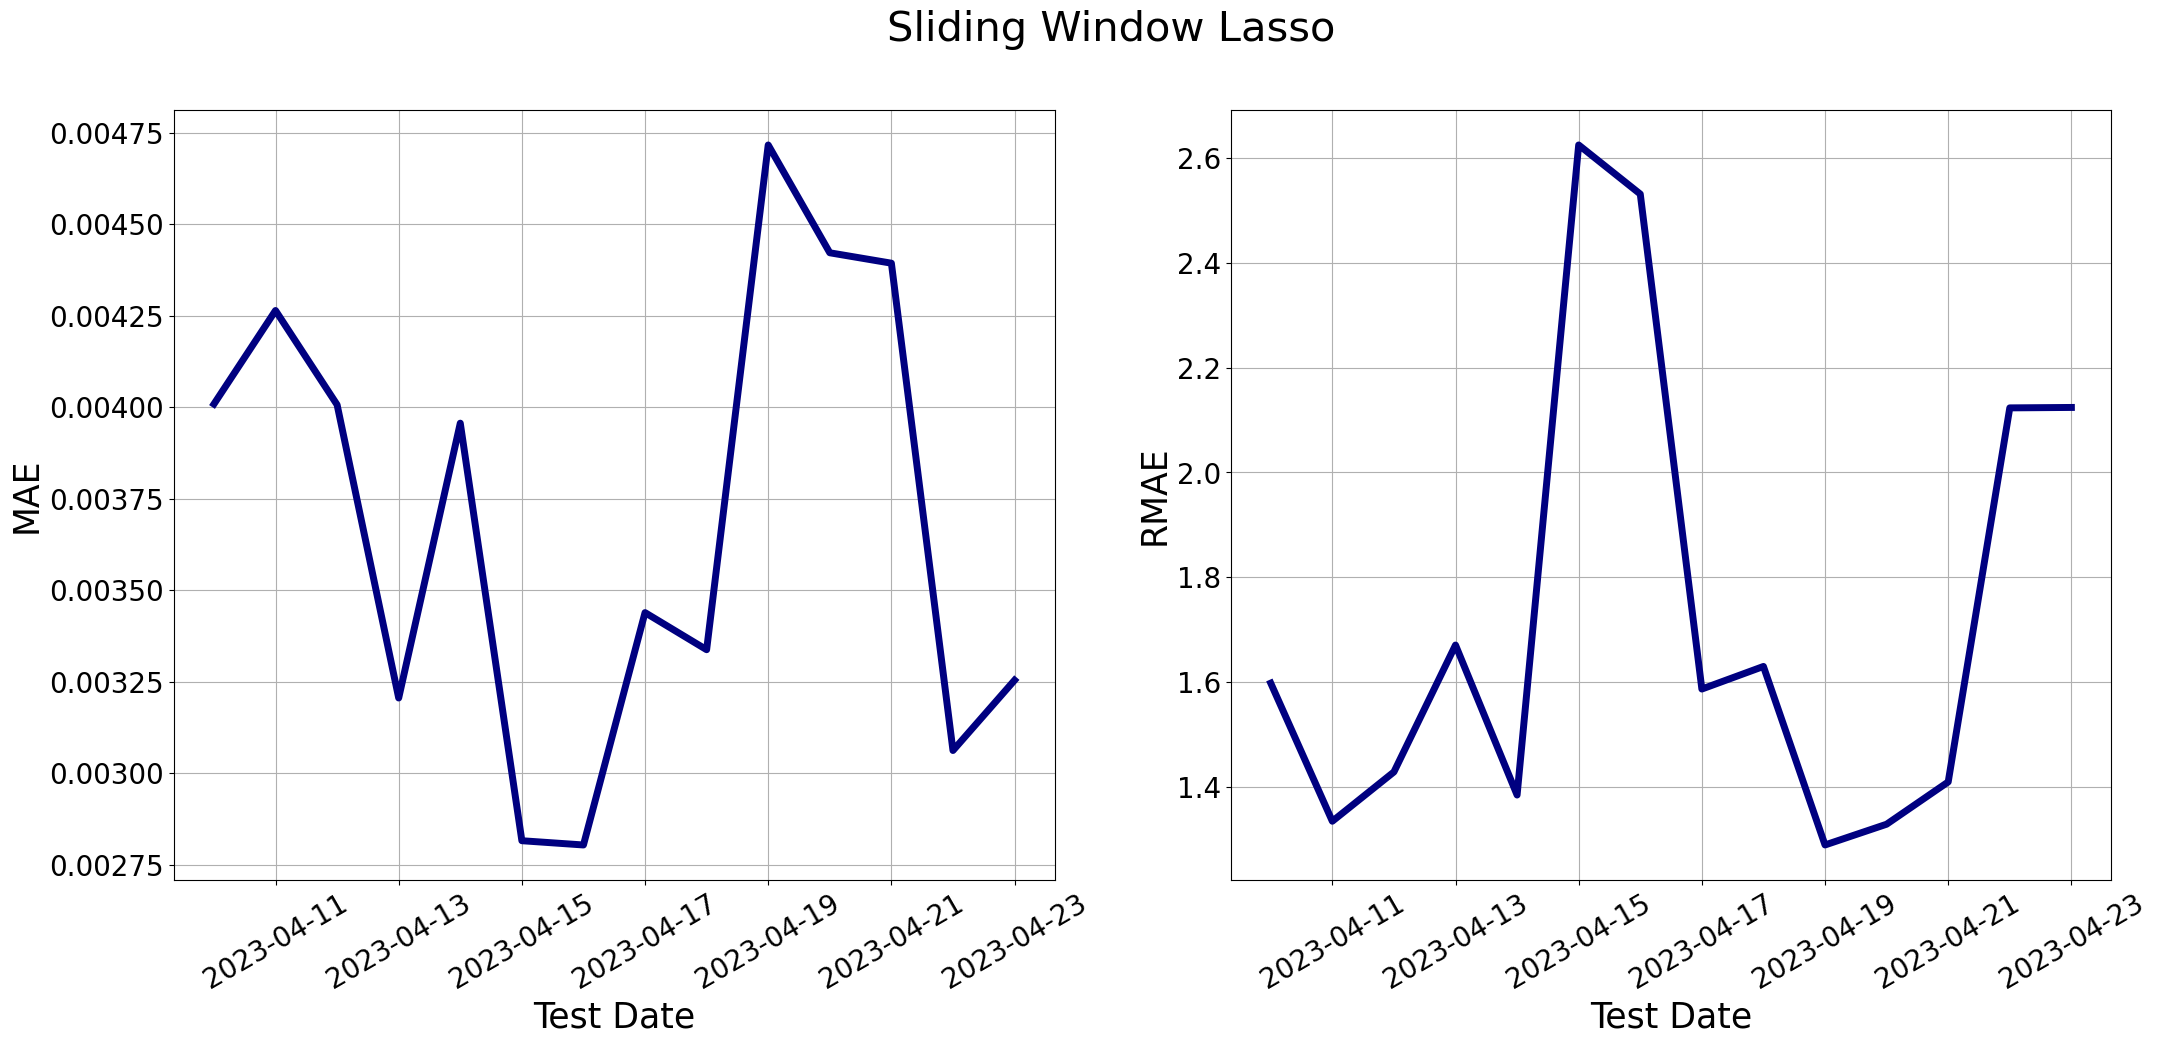

In [171]:
sliding_mae_lasso = pd.DataFrame({i: j['mae'] for i,j in res_sliding_lasso.items()}.items(), columns = ['test_date', 'mae'])
sliding_rmae_lasso = pd.DataFrame({i: j['rmae'] for i,j in res_sliding_lasso.items()}.items(), columns = ['test_date', 'rmae'])

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (25, 10))

sns.lineplot(sliding_mae_lasso['test_date'], sliding_mae_lasso['mae'], linewidth = 5, color = 'navy', ax = ax[0])
sns.lineplot(sliding_rmae_lasso['test_date'], sliding_rmae_lasso['rmae'], linewidth = 5, color = 'navy', ax = ax[1])
for i in ax:
    i.grid()
    i.tick_params(labelsize = 20)
    i.set_xlabel('Test Date', fontsize = 25)
    i.xaxis.set_tick_params(rotation = 30)

ax[0].set_ylabel('MAE', fontsize = 25)
ax[1].set_ylabel('RMAE', fontsize = 25)
    
plt.suptitle('Sliding Window Lasso', fontsize = 30)
plt.savefig('Sliding Window Lasso.jpg', bbox_tight = True)
plt.show()

In [173]:
res_expanding_lasso = expanding_window_cv(df, 'rv_LT', 7, 'received_time_r', 1, Lasso, params, scaling = True)

2023-04-03 2023-04-09 [datetime.date(2023, 4, 10)]
2023-04-03 2023-04-10 [datetime.date(2023, 4, 11)]
2023-04-03 2023-04-11 [datetime.date(2023, 4, 12)]
2023-04-03 2023-04-12 [datetime.date(2023, 4, 13)]
2023-04-03 2023-04-13 [datetime.date(2023, 4, 14)]
2023-04-03 2023-04-14 [datetime.date(2023, 4, 15)]
2023-04-03 2023-04-15 [datetime.date(2023, 4, 16)]
2023-04-03 2023-04-16 [datetime.date(2023, 4, 17)]
2023-04-03 2023-04-17 [datetime.date(2023, 4, 18)]
2023-04-03 2023-04-18 [datetime.date(2023, 4, 19)]
2023-04-03 2023-04-19 [datetime.date(2023, 4, 20)]
2023-04-03 2023-04-20 [datetime.date(2023, 4, 21)]
2023-04-03 2023-04-21 [datetime.date(2023, 4, 22)]
2023-04-03 2023-04-22 [datetime.date(2023, 4, 23)]


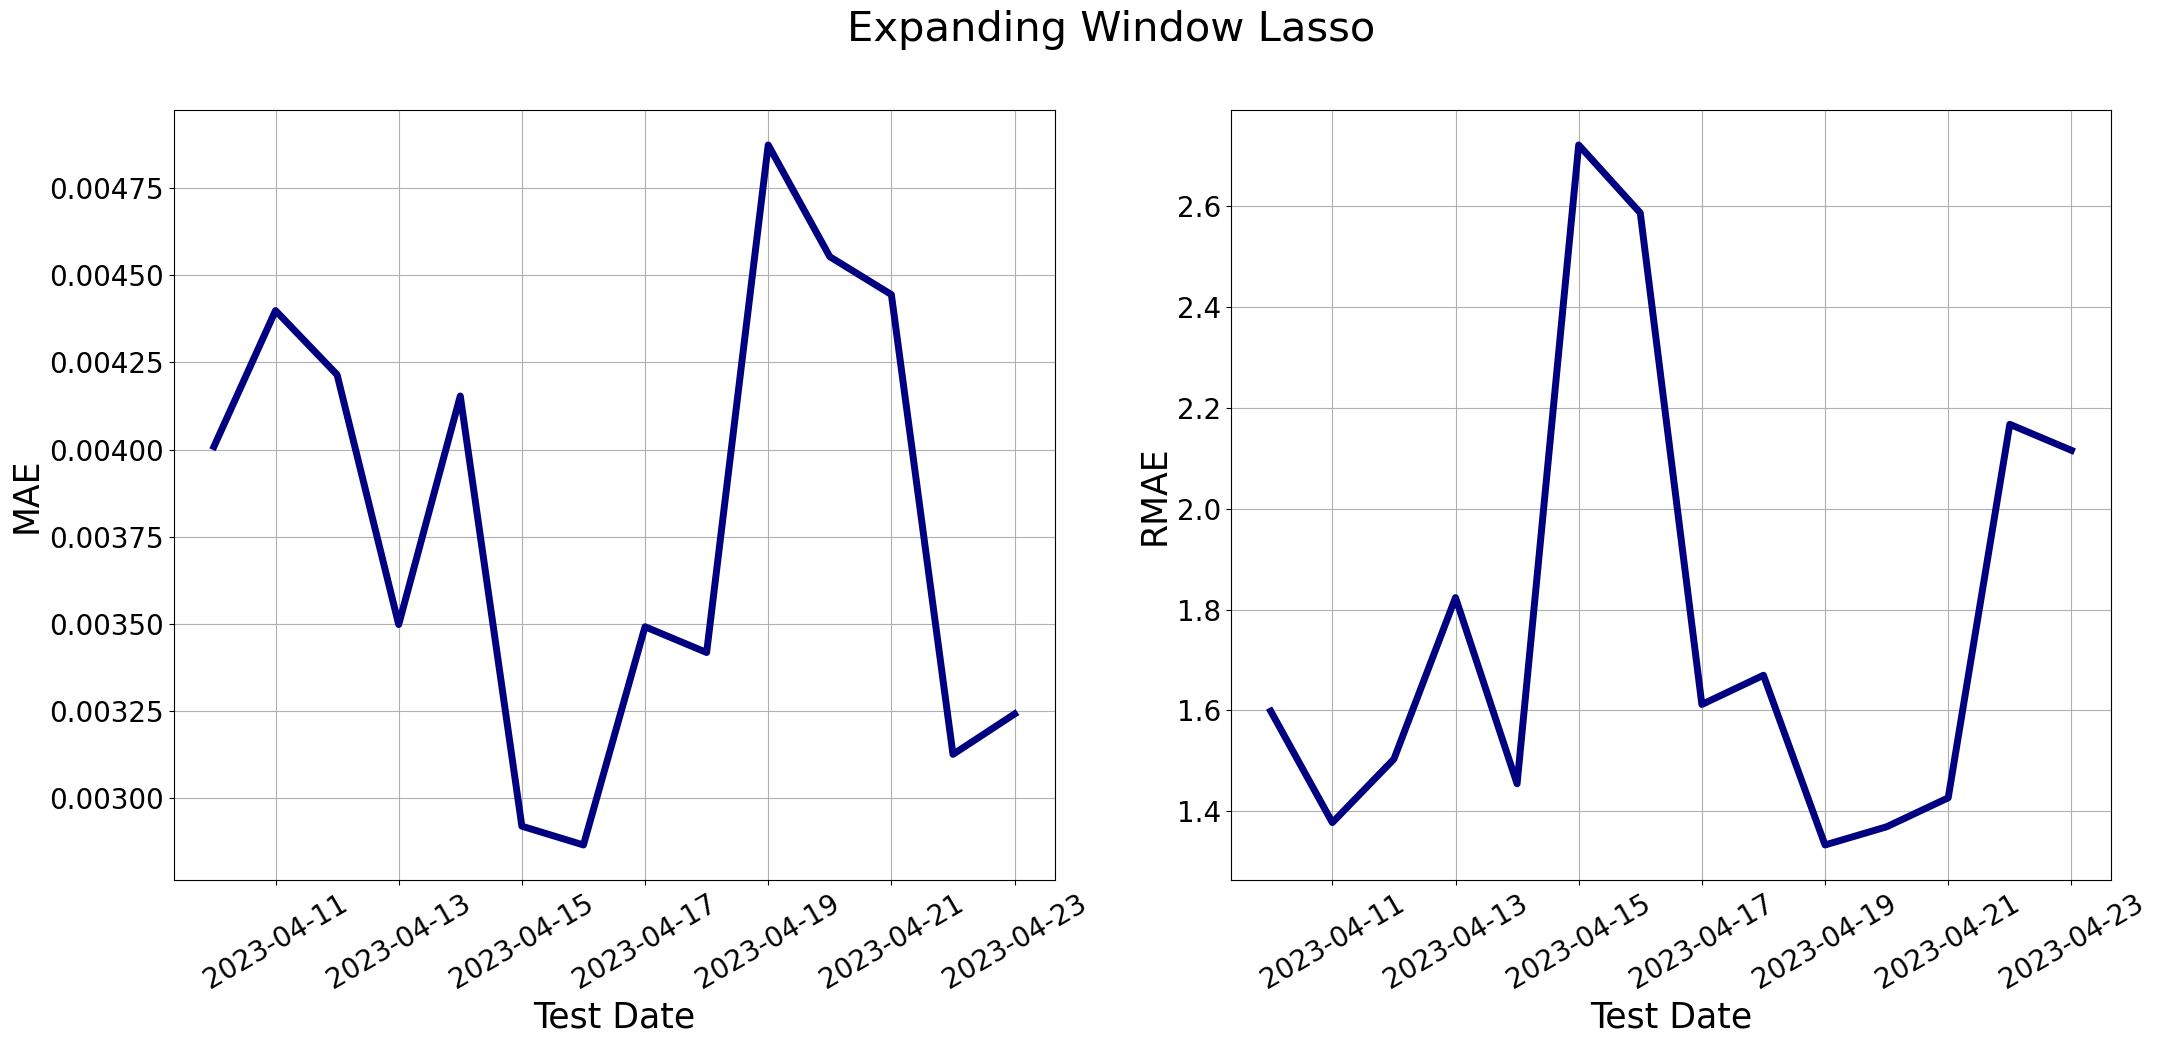

In [174]:
expanding_mae_lasso = pd.DataFrame({i: j['mae'] for i,j in res_expanding_lasso.items()}.items(), columns = ['test_date', 'mae'])
expanding_rmae_lasso = pd.DataFrame({i: j['rmae'] for i,j in res_expanding_lasso.items()}.items(), columns = ['test_date', 'rmae'])

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (25, 10))

sns.lineplot(expanding_mae_lasso['test_date'], expanding_mae_lasso['mae'], linewidth = 5, color = 'navy', ax = ax[0])
sns.lineplot(expanding_rmae_lasso['test_date'], expanding_rmae_lasso['rmae'], linewidth = 5, color = 'navy', ax = ax[1])
for i in ax:
    i.grid()
    i.tick_params(labelsize = 20)
    i.set_xlabel('Test Date', fontsize = 25)
    i.xaxis.set_tick_params(rotation = 30)

ax[0].set_ylabel('MAE', fontsize = 25)
ax[1].set_ylabel('RMAE', fontsize = 25)
    
plt.suptitle('Expanding Window Lasso', fontsize = 30)
plt.savefig('Expanding Window Lasso.jpg', bbox_tight = True)
plt.show()

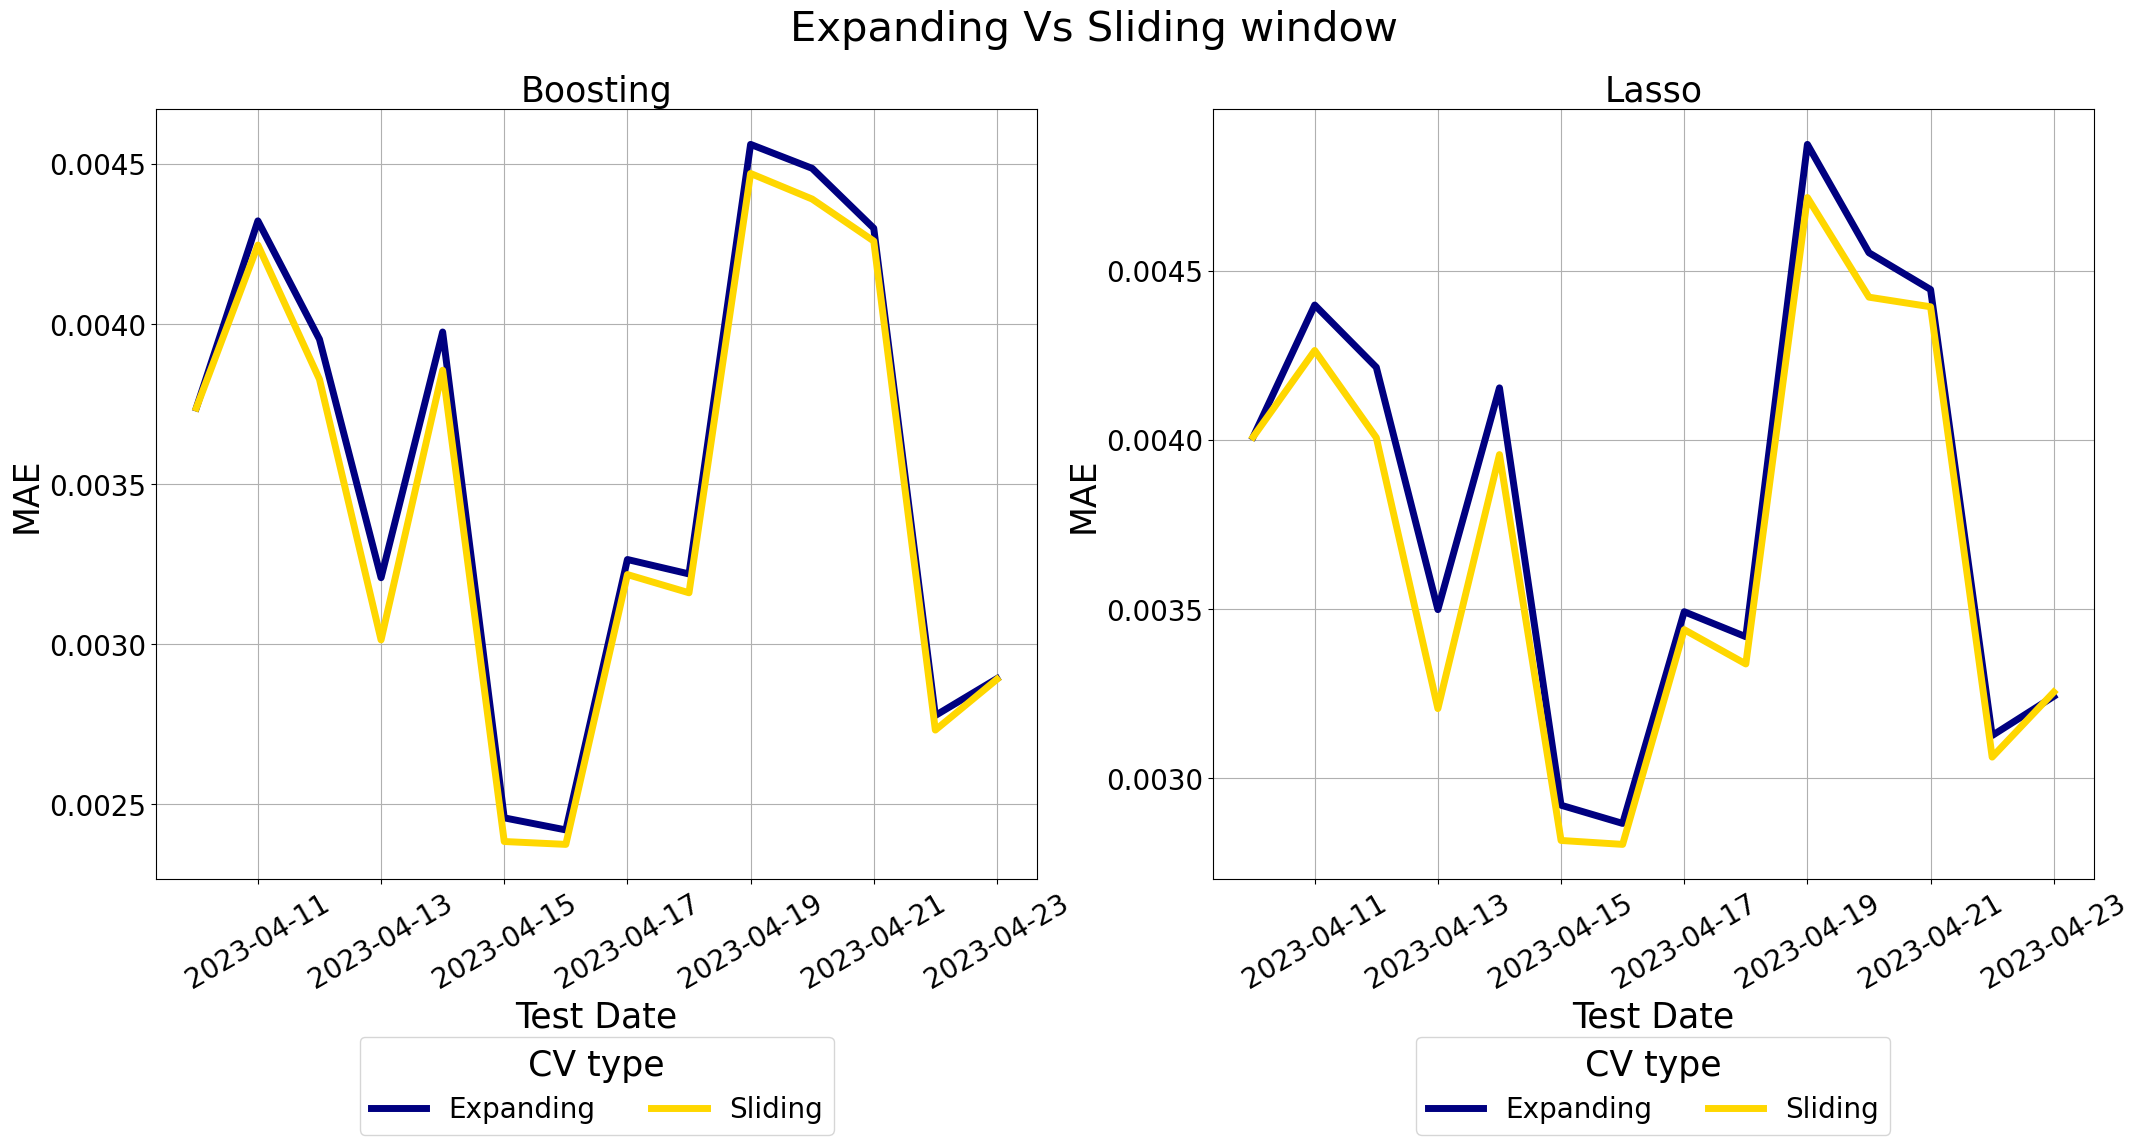

In [182]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (25, 10))

sns.lineplot(expanding_mae['test_date'], expanding_mae['mae'], linewidth = 5, color = 'navy', ax = ax[0], label = 'Expanding')
sns.lineplot(sliding_mae['test_date'], sliding_mae['mae'], linewidth = 5, color = 'gold', ax = ax[0], label = 'Sliding')
sns.lineplot(expanding_mae_lasso['test_date'], expanding_mae_lasso['mae'], linewidth = 5, color = 'navy', ax = ax[1], label = 'Expanding')
sns.lineplot(sliding_mae_lasso['test_date'], sliding_mae_lasso['mae'], linewidth = 5, color = 'gold', ax = ax[1], label = 'Sliding')

for i in ax:
    i.grid()
    i.tick_params(labelsize = 20)
    i.set_xlabel('Test Date', fontsize = 25)
    i.xaxis.set_tick_params(rotation = 30)
    i.legend(fontsize = 20, title = 'CV type', title_fontsize = 25, bbox_to_anchor = (0.5, -0.35), 
             loc = 'lower center', ncol = 2)

ax[0].set_ylabel('MAE', fontsize = 25)
ax[1].set_ylabel('MAE', fontsize = 25)

ax[0].set_title('Boosting', fontsize = 25)
ax[1].set_title('Lasso', fontsize = 25)
    
plt.suptitle('Expanding Vs Sliding window', fontsize = 30)
plt.savefig('Expanding Vs Sliding window.jpg', bbox_tight = True)
plt.show()

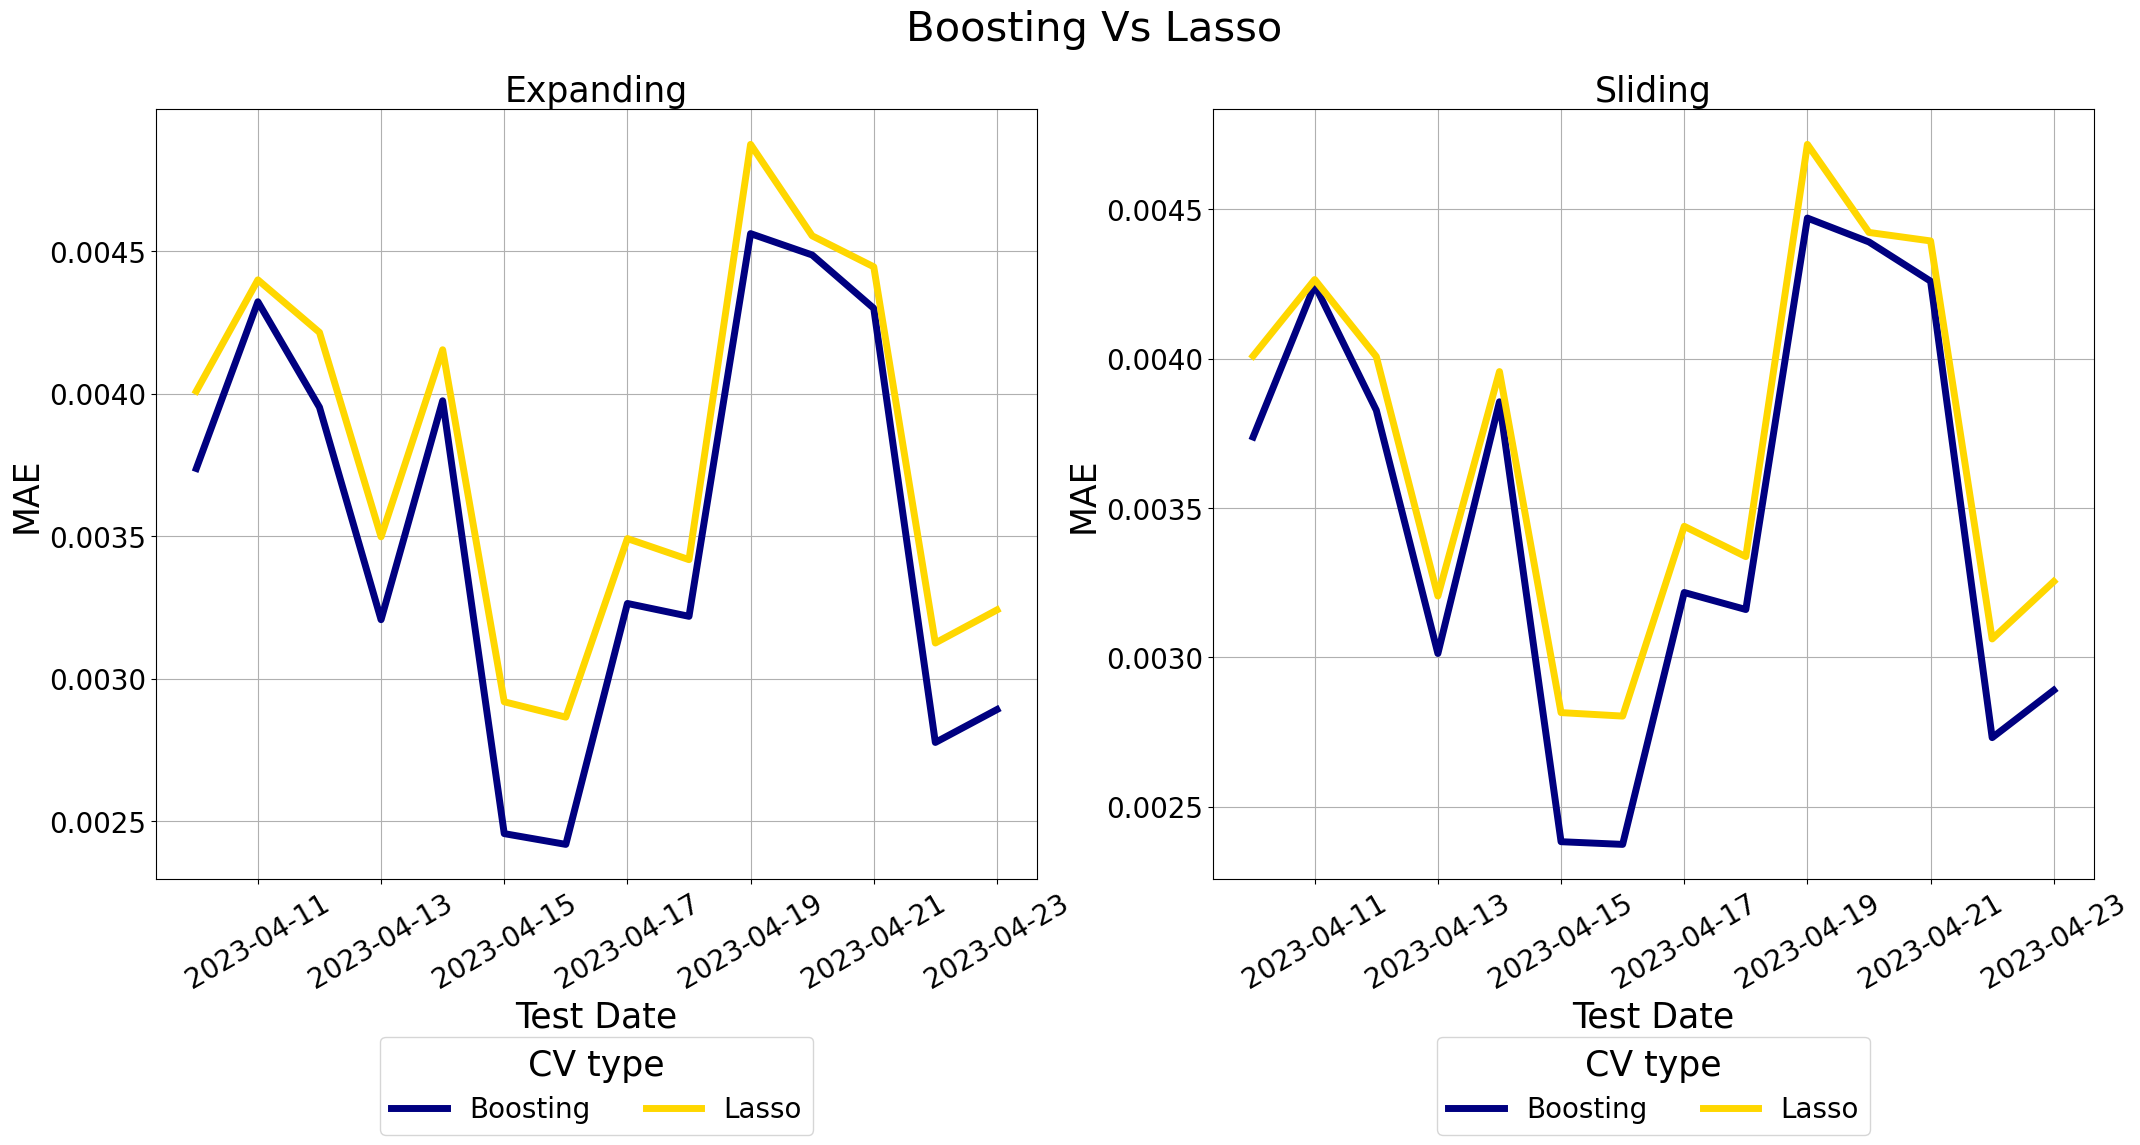

In [184]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (25, 10))

sns.lineplot(expanding_mae['test_date'], expanding_mae['mae'], linewidth = 5, color = 'navy', ax = ax[0], label = 'Boosting')
sns.lineplot(expanding_mae_lasso['test_date'], expanding_mae_lasso['mae'], linewidth = 5, color = 'gold', ax = ax[0], label = 'Lasso')

sns.lineplot(sliding_mae['test_date'], sliding_mae['mae'], linewidth = 5, color = 'navy', ax = ax[1], label = 'Boosting')
sns.lineplot(sliding_mae_lasso['test_date'], sliding_mae_lasso['mae'], linewidth = 5, color = 'gold', ax = ax[1], label = 'Lasso')

for i in ax:
    i.grid()
    i.tick_params(labelsize = 20)
    i.set_xlabel('Test Date', fontsize = 25)
    i.xaxis.set_tick_params(rotation = 30)
    i.legend(fontsize = 20, title = 'CV type', title_fontsize = 25, bbox_to_anchor = (0.5, -0.35), 
             loc = 'lower center', ncol = 2)

ax[0].set_ylabel('MAE', fontsize = 25)
ax[1].set_ylabel('MAE', fontsize = 25)

ax[0].set_title('Expanding', fontsize = 25)
ax[1].set_title('Sliding', fontsize = 25)
    
plt.suptitle('Boosting Vs Lasso', fontsize = 30)
plt.savefig('Boosting Vs Lasso.jpg', bbox_tight = True)
plt.show()